In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
import jax
import jax.numpy as np
import jax.tree_util as jtu

#catch nans
jax.config.update("jax_debug_nans", True)
#jax.config.update("jax_enable_x64", True)

import jax_md
import equinox as eqx


from typing import Any, Callable, Union, Sequence


import matplotlib.pyplot as plt
from jax_morph.visualization import draw_circles_ctype, draw_circles_chem

In [3]:
@jax.custom_vjp
def print_tangent(x):
    # This function will be used in the forward pass
    return x

def print_fwd(x):
    # Forward pass function for custom VJP
    return print_tangent(x), x

def print_bwd(x, g):
    # Backward pass function for custom VJP
    print(jtu.tree_flatten(g))
    print()
    
    return (g,)

print_tangent.defvjp(print_fwd, print_bwd)

In [4]:
@jax.custom_vjp
def normalize_grads(x):
    # This function will be used in the forward pass
    return x

def normalize_grads_fwd(x):
    # Forward pass function for custom VJP
    return normalize_grads(x), x

def normalize_grads_bwd(x, g):
    # Backward pass function for custom VJP
    
    #normalize gradients
    g = jtu.tree_map(lambda x: x / (np.linalg.norm(x)+1e-20), g)
    
    return (g,)

normalize_grads.defvjp(normalize_grads_fwd, normalize_grads_bwd)

In [5]:
key = jax.random.PRNGKey(0)

# Cell State

In [6]:
class BaseCellState(eqx.Module):
    '''
    Module containing the basic features of a system state.

    '''

    # METHODS
    displacement:   jax_md.space.DisplacementFn = eqx.field(static=True)
    shift:          jax_md.space.ShiftFn = eqx.field(static=True)

    # STATE
    position:   jax.Array
    celltype:   jax.Array
    radius:     jax.Array
    division:   jax.Array


    @classmethod
    def empty(cls, n_dim=2, n_cell_types=1):

        '''
        Intializes a CellState with no cells (empty data structures, with correct shapes).

        Parameters
        ----------
        n_dim: int
            Number of spatial dimensions.

        '''

        assert n_dim == 2 or n_dim == 3, 'n_dim must be 2 or 3'

        disp, shift = jax_md.space.free()
        

        args = {
            'displacement'  :   disp,
            'shift'         :   shift,
            'position'  :   np.empty(shape=(0, n_dim), dtype=np.float32),
            'celltype'  :   np.empty(shape=(0,n_cell_types), dtype=np.float32),
            'radius'    :   np.empty(shape=(0,1), dtype=np.float32),
            'division'   :   np.empty(shape=(0,1), dtype=np.float32),
            }
        
        return cls(**args)


In [7]:
class CellState(BaseCellState):
    chemical:           jax.Array
    secretion_rate:     jax.Array
    #chemical_grad:      jax.Array
    hidden_state:       jax.Array
    #mechanical_stress:  jax.Array


    @classmethod
    def empty(cls, n_dim=2, n_chem=1, hidden_size=10):

        a = BaseCellState.empty(n_dim).__dict__

        new_args = {
            'chemical' :   np.empty(shape=(0, n_chem), dtype=np.float32),
            'secretion_rate' :   np.empty(shape=(0, n_chem), dtype=np.float32),
            #'chemical_grad' :   np.empty(shape=(0, int(n_dim*n_chem)), dtype=np.float32),
            'hidden_state' :   np.empty(shape=(0, hidden_size), dtype=np.float32),
            #'mechanical_stress' :  np.empty(shape=(0,1), dtype=np.float32),
            }
        
        a.update(new_args)

        return cls(**a)

# Environment

In [8]:
import abc

class SimulationStep(eqx.Module):

    @abc.abstractmethod
    def __call__(self, state, *, key=None, **kwargs):
        pass

## Cell division

**NOTE**: The whole Gumbel-Softmax is useless in this context. By formulating copy operations as multiplications autodiff is already able to deal with this situation. The gradient of the operation is just the copy matrix!

In [9]:
class CellDivisionReparam(SimulationStep):
    birth_radius_multiplier:    float
    per_cell_probability:       bool = eqx.field(static=True)
    softmax_T:                  float = eqx.field(static=True)
    #inference:                  bool = eqx.field(static=True)

    # def _logits_to_onehot(self, logits):

    #     onehot = jax.nn.one_hot(np.argmax(logits), logits.shape[-1])

    #     #straight through gradient
    #     zero = logits - jax.lax.stop_gradient(logits)

    #     return zero + jax.lax.stop_gradient(onehot)
    


    def __init__(self, *, birth_radius_multiplier=float(1/np.sqrt(2)), softmax_T=1., per_cell_probability=False, **kwargs): #inference=True

        self.birth_radius_multiplier = birth_radius_multiplier
        self.per_cell_probability = per_cell_probability
        self.softmax_T = softmax_T

        #self.inference = inference
        

    def __call__(self, state, *, key=None, **kwargs):#, inference=None):

        # if inference is None:
        #     inference = self.inference

        idx_new_cell = np.count_nonzero(state.celltype.sum(1))


        if self.per_cell_probability:
            raise NotImplementedError('per_cell_probability not implemented yet')
        
        else:

            #split key
            subkey_div, subkey_place = jax.random.split(key,2)
            
            p = state.division/state.division.sum()
            p = p.squeeze() #remove "empty" dimensions -> (N,1) -> (N,)


            safe_p = np.where(p > 0., p, 1)
            logp = np.where(p > 0., np.log(safe_p), 0.)

            logits = (-logp - jax.random.gumbel(subkey_div, shape=logp.shape))
            idx_dividing_cell = np.argmin(logits)

            
            if self.softmax_T > 0.:

                logits = np.where(p>0.,-logits/self.softmax_T, -np.inf)
                new_cell_contribs = np.where(p>0., jax.nn.softmax(logits), 0)

            else:
                new_cell_contribs = jax.nn.one_hot(idx_dividing_cell, num_classes=len(p))
            

            division_matrix = np.eye(state.celltype.shape[0]).at[idx_new_cell].set(new_cell_contribs)

            state = jax.tree_map(lambda x: np.dot(division_matrix, x), state)


            #resize cell radii
            resize_rad = state.radius.at[idx_new_cell].set(state.radius[idx_new_cell]*self.birth_radius_multiplier)
            # resize_rad = resize_rad.at[idx_dividing_cell].set(state.radius[idx_dividing_cell]*self.birth_radius_multiplier)

            resize_rad -= (1 - self.birth_radius_multiplier)*np.where(p>0.,new_cell_contribs,0.)[:,None] * resize_rad

            state = eqx.tree_at(lambda s: s.radius, state, resize_rad)
            


            ### POSITION OF NEW CELLS
            angle = jax.random.uniform(subkey_place, minval=0., maxval=2*np.pi)

            cell_displacement = self.birth_radius_multiplier*np.array([np.cos(angle),np.sin(angle)])

            new_position = state.position.at[idx_new_cell].set(state.position[idx_dividing_cell]-cell_displacement)
            #new_position = new_position.at[idx_dividing_cell].set(new_position[idx_dividing_cell]+cell_displacement)

            new_position += np.where(p>0.,new_cell_contribs,0.)[:,None] * cell_displacement

            state = eqx.tree_at(lambda s: s.position, state, new_position)
        

        return state

## Cell growth

In [10]:
class CellGrowth(SimulationStep):
    max_radius:     float
    growth_rate:    float
    growth_type:    str = eqx.field(static=True)
    
    def __init__(self, *, 
                 growth_rate=1., 
                 max_radius=.5, 
                 growth_type='linear',
                 **kwargs
                 ):

        # if not hasattr(state, 'radius'):
        #     raise AttributeError('CellState must have "radius" attribute')
        
        if growth_type not in ['linear', 'exponential']:
            raise ValueError('growth_type must be either "linear" or "exponential"')
        
        self.growth_rate = growth_rate
        self.max_radius = max_radius
        self.growth_type = growth_type


    def __call__(self, state, *, key=None, **kwargs):

        if self.growth_type == 'linear':
            new_radius = state.radius + self.growth_rate
        elif self.growth_type == 'exponential':
            new_radius = state.radius*np.exp(self.growth_rate)

        new_radius = np.where(new_radius > self.max_radius, self.max_radius, new_radius)*np.where(state.celltype.sum(1)[:,None]>0, 1, 0)

        state = eqx.tree_at(lambda s: s.radius, state, new_radius)

        return state

## Mechanical

In [11]:
class SGDMechanicalRelaxation(SimulationStep):
    mechanical_potential:   eqx.Module
    relaxation_steps:       int = eqx.field(default=25, static=True)
    dt:                     float = eqx.field(default=8e-4, static=True)


    def _sgd(self, state, pair_potential):

        init, apply = jax_md.minimize.gradient_descent(pair_potential, state.shift, self.dt) 
 
        def scan_fn(opt_state, i):
            return apply(opt_state), 0.

        #relax system
        opt_state = init(state.position)
        opt_state, _ = jax.lax.scan(scan_fn, opt_state, np.arange(self.relaxation_steps))

        return opt_state
    

    def __call__(self, state, *, key=None, **kwargs):

        #generate morse pair potential
        energy_fn = self.mechanical_potential.energy_fn(state)
        
        #minimize
        new_positions = self._sgd(state, energy_fn)

        state = eqx.tree_at(lambda s: s.position, state, new_positions)

        return state

In [12]:
#Define Potential ABC
class MechanicalInteractionPotential(eqx.Module):

    @abc.abstractmethod
    def energy_fn(self, state, *, per_particle):
        pass


class MorsePotential(MechanicalInteractionPotential):
    epsilon:   Union[float, jax.Array] = 3.
    alpha:     float = 2.8
    r_cutoff:  float = eqx.field(default=2., static=True)
    r_onset:   float = eqx.field(default=1.7, static=True)


    def _calculate_epsilon_matrix(self, state):

        if np.atleast_1d(self.epsilon).size == 1:
            alive = np.where(state.celltype.sum(1) > 0, 1, 0)
            epsilon_matrix = (np.outer(alive, alive)-np.eye(alive.shape[0]))*self.epsilon


        elif isinstance(self.epsilon, jax.interpreters.xla.DeviceArray):
            
            ### implement general logic for multiple cell types
            raise NotImplementedError('Multiple cell types not implemented yet')


        return epsilon_matrix
    

    def _calculate_sigma_matrix(self, state):

        # sigma_matrix = state.radius[:,None] + state.radius[None,:]

        # In principle this should be the right expression:
        # alive = np.where(state.celltype.sum(1) > 0, 1, 0)
        # sigma_matrix = (state.radius + state.radius.T - 2*np.diag(test_state.radius.squeeze()))*np.outer(alive, alive)
        # BUT since we already put epsilon = 0 for non-interacting cells, we can save on some operations

        sigma_matrix = state.radius + state.radius.T

        return sigma_matrix
    

    def energy_fn(self, state, *, per_particle=False):

        epsilon_matrix = self._calculate_epsilon_matrix(state)
        sigma_matrix = self._calculate_sigma_matrix(state)

        #generate morse pair potential
        morse_energy = jax_md.energy.morse_pair(state.displacement,
                                                alpha=self.alpha,
                                                epsilon=epsilon_matrix,
                                                sigma=sigma_matrix, 
                                                r_onset=self.r_onset, 
                                                r_cutoff=self.r_cutoff,
                                                per_particle=per_particle
                                                )
        
        return morse_energy


## Diffusion

In [13]:
class SteadyStateDiffusion(SimulationStep):
    diffusion_coeff:    Union[float, jax.Array]
    degradation_rate:   Union[float, jax.Array]
    _vmap_diff_inaxes:  tuple = eqx.field(static=True)

    def __init__(self, *, diffusion_coeff=2., degradation_rate=1., **kwargs):

        self.diffusion_coeff = diffusion_coeff
        self.degradation_rate = degradation_rate

        _inaxes_diffcoef = 0 if np.atleast_1d(self.diffusion_coeff).size > 1 else None
        _inaxes_degrate = 0 if np.atleast_1d(self.degradation_rate).size > 1 else None
        self._vmap_diff_inaxes = (1, _inaxes_diffcoef, _inaxes_degrate, None)


    def __call__(self, state, *, key=None, **kwargs):

        #calculate all pairwise distances
        dist = jax_md.space.map_product(jax_md.space.metric(state.displacement))(state.position, state.position)


        alive_cells = np.where(state.celltype.sum(1) > 0, 1, 0)

        #prevent division by zero
        dist *= np.where(np.outer(alive_cells, alive_cells)>0, 1, -1)
        dist += np.where(np.outer(alive_cells, alive_cells)>0, 0, -1)
        dist += -np.eye(dist.shape[0])

        #adjacency matrix
        # zero out connections to inexistent cells
        A = 1/dist
        A = (np.where(A>0, A, 0))**2


        #calculate graph laplacian
        L = np.diag(np.sum(A, axis=0)) - A
    

        def _ss_chemfield(P, D, K, L):

            #update laplacian with degradation
            L = D*L + K*np.eye(L.shape[0])

            #solve for steady state
            c = np.linalg.solve(L, P)

            return c
        
        #calculate steady state chemical field
        _ss_chemfield = jax.vmap(_ss_chemfield, in_axes=self._vmap_diff_inaxes, out_axes=1)

        new_chem = _ss_chemfield(state.secretion_rate, self.diffusion_coeff, self.degradation_rate, L)

        #update chemical field
        state = eqx.tree_at(lambda s: s.chemical, state, new_chem)

        return state

# Cell internals

## Chemical gradients

In [14]:
class LocalChemicalGradients(SimulationStep):
    neighbor_radius:    Union[float,None] = eqx.field(static=True)


    def __init__(self, *, neighbor_radius=None, **kwargs):

        self.neighbor_radius = neighbor_radius



    def __call__(self, state, *, key=None, **kwargs):

        # mask only cells that exist
        c_alive = state.celltype.sum(1)>0.
        c_alive = np.outer(c_alive, c_alive)

        # displacements between cell pairs (ncells x ncells x ndim_space)
        disp = jax.vmap(jax.vmap(state.displacement, in_axes=[0,None]), in_axes=[None,0])(state.position, state.position)

        # distances btw cell pairs
        dist = (disp**2).sum(2)

        # avoid division by zero in gradient calculation
        safe_dist = np.where(dist>0., dist, 1)
        dist = np.where(dist>0., safe_dist, 0)

        # dist w/ non-existing cells are zeroed out
        dist *= c_alive

        #jax.debug.print('{x}', x=(disp**2).sum(2))

        # consider as neigbors:
        # - cells less than one radius away (+ small tolerance)
        # - cells differents from themselves
        # - cells that exist
        if None == self.neighbor_radius:
            # "touching" distance betw. cells
            R = (state.radius+state.radius.T)*c_alive
        else:
            R = (self.neighbor_radius)*c_alive
        
        neig = (dist<R)*(dist>0.)

        #safe_dist = np.where(dist>0, dist, 1)

        # normalize all displacements
        norm_disp = (disp*neig[:,:,None])/(dist[:,:,None]+1e-8)
        norm_disp = np.where((dist>0)[:,:,None], (disp*neig[:,:,None])/safe_dist[:,:,None], 0)

        # calculates x and y components of grad for single chemical
        def _grad_chem(chem):
            return (norm_disp*chem.ravel()[:,None]).sum(1)
            

        #vectorize over chemicals
        #OUTPUT SHAPE: ncells x ndim x nchem
        _grad_chem = jax.vmap(_grad_chem, in_axes=1, out_axes=2)

        #calc grads (no non-existing cells or lone cells w/ no neighbors)
        chemgrads = _grad_chem(state.chemical)
            
        # transform into ncells x (grad_x + grad_y)
        #reshape like ncells x ndim x nchem to revert
        chemgrads = chemgrads.reshape(state.celltype.shape[0], -1)

        #update state
        state = eqx.tree_at(lambda s: s.chemical_grad, state, chemgrads)

        return state

## Mechanical stress

In [15]:
class LocalMechanicalStress(SimulationStep):
    mechanical_potential:       eqx.Module


    def __init__(self, mechanical_potential, **kwargs):
        self.mechanical_potential = mechanical_potential

    
    def __call__(self, state, *, key=None, **kwargs):

        #generate pair potential
        pair_potential = self.mechanical_potential.energy_fn(state)
        
        forces = jax.jacrev(pair_potential)(state.position)
        
        # F_ij = force on i by j, r_ij = displacement from i to j
        drs = jax_md.space.map_product(state.displacement)(state.position, state.position)
        
        stresses = np.sum(np.multiply(forces, np.sign(drs)), axis=(0, 2))[:,None]
        stresses = np.where(state.celltype.sum(1)[:,None] > 0, stresses, 0.)

        state = eqx.tree_at(lambda s: s.mechanical_stress, state, stresses)

        return state

## Division Rates

### TODO: Implement Linear and MLP that make it easy to specify different layer sizes and initializations

In [16]:
# class Linear(eqx.Module):



# class MLP(eqx.Module):
#     layers:     Sequence[eqx.nn.Linear]
#     activation: Callable = eqx.field(static=True)
#     final_activation: Callable = eqx.field(static=True)
#     use_bias:   bool = eqx.field(static=True)
#     w_init:     Callable = eqx.field(static=True)
#     b_init:     Callable = eqx.field(static=True)

#     def __init__(self, 
#                  output_sizes, 
#                  activation=jax.nn.relu,
#                  *,
#                  final_activation=jax.nn.sigmoid, 
#                  use_bias=True,
#                  w_init=jax.nn.initializers.glorot_normal(),
#                  b_init=jax.nn.initializers.zeros(),
#                  key, 
#                  **kwargs
#                  ):

#         layers = [eqx.nn.Linear(width_sizes[i], width_sizes[i+1], use_bias=use_bias) for i in range(len(width_sizes)-1)]

#         self.layers = layers
#         self.activation = activation
#         self.final_activation = final_activation
#         self.use_bias = use_bias

In [17]:
class DivisionMLP(SimulationStep):
    input_fields:        Sequence[str] = eqx.field(static=True)
    transform_output:    Union[Callable,None] = eqx.field(static=True)
    mlp:                 eqx.nn.MLP


    def __init__(self, state, 
                 input_fields, 
                 *,
                 key,
                 w_init=jax.nn.initializers.constant(0.),
                 transform_output=None,
                 final_activation=jax.nn.softplus,
                 **kwargs
                 ):

        self.transform_output = transform_output
        self.input_fields = input_fields

        in_shape = np.concatenate([getattr(state, field) for field in input_fields], axis=1).shape[-1]
        out_shape = 1

        self.mlp = eqx.nn.MLP(in_size=in_shape,
                            out_size=out_shape,
                            depth=0,
                            width_size=0,
                            activation=jax.nn.leaky_relu,
                            final_activation=final_activation,
                            key=key,
                            **kwargs
                            )
        
        self.mlp = eqx.tree_at(lambda m: m.layers[0].weight, self.mlp, w_init(key, self.mlp.layers[0].weight.shape))


    def __call__(self, state, *, key=None, **kwargs):

        #concatenate input features
        in_features = np.concatenate([getattr(state, field) for field in self.input_fields], axis=1)


        #apply MLP
        division = jax.vmap(self.mlp)(in_features)


        #transform output
        if self.transform_output is not None:
            division = self.transform_output(state, division)


        ##### MISSING RADIUS DEPENDENCY

        #keep only alive cells
        division = np.where(state.celltype.sum(1)[:,None] > 0, division, 0.)

        #update state
        state = eqx.tree_at(lambda s: s.division, state, division)

        return state    

## Secretion Rates

In [18]:
class SecretionMLP(SimulationStep):
    input_fields:        Sequence[str] = eqx.field(static=True)
    transform_output:    Union[Callable,None] = eqx.field(static=True)
    ctype_sec_chem:      eqx.field(static=True)
    mlp:                 eqx.nn.MLP
    #_sec_mask:           Callable = eqx.field(static=True)


    def __init__(self, 
                state, 
                input_fields,
                *,
                key,
                ctype_sec_chem=None,
                w_init=jax.nn.initializers.orthogonal(),
                transform_output=None,
                final_activation=jax.nn.softplus,
                **kwargs
                ):

        self.transform_output = transform_output
        self.input_fields = input_fields

        in_shape = np.concatenate([getattr(state, field) for field in input_fields], axis=1).shape[1]
        out_shape = state.chemical.shape[-1]

        self.mlp = eqx.nn.MLP(in_size=in_shape,
                            out_size=out_shape,
                            depth=0,
                            width_size=0,
                            activation=jax.nn.leaky_relu,
                            final_activation=final_activation,
                            key=key,
                            **kwargs
                            )
        
        self.mlp = eqx.tree_at(lambda m: m.layers[0].weight, self.mlp, w_init(key, self.mlp.layers[0].weight.shape))


        if ctype_sec_chem is None:
            self.ctype_sec_chem = [1.]*state.chemical.shape[1]
        else:
            self.ctype_sec_chem = ctype_sec_chem

        # self.ctype_sec_chem = np.vstack((np.zeros(state.chemical.shape[1]), ctype_sec_chem))

        # self._sec_mask = jax.vmap(lambda ctype: self.ctype_sec_chem[np.int8(np.rint(ctype))])


    def __call__(self, state, *, key=None, **kwargs):

        #concatenate input features
        in_features = np.concatenate([getattr(state, field) for field in self.input_fields], axis=1)


        #apply MLP
        secretion_rate = jax.vmap(self.mlp)(in_features)

        #transform output
        if self.transform_output is not None:
            secretion_rate = self.transform_output(state, secretion_rate)

        #keep only alive cells
        # secretion_rate = np.where(state.celltype.sum(1)[:,None] > 0, secretion_rate, 0.)

        #apply secretion mask
        # secretion_rate = self._sec_mask(state.celltype.sum(1))*secretion_rate


        sec_mask = state.celltype @ np.atleast_2d(self.ctype_sec_chem)

        secretion_rate = sec_mask*secretion_rate


        #update state
        state = eqx.tree_at(lambda s: s.secretion_rate, state, secretion_rate)

        return state

## Hidden State

In [19]:
class HiddenStateMLP(SimulationStep):
    input_fields:        Sequence[str] = eqx.field(static=True)
    transform_output:    Union[Callable,None] = eqx.field(static=True)
    mlp:                 eqx.nn.MLP
    memory_decay:        Union[float, jax.Array]


    def __init__(self, 
                state, 
                input_fields,
                *,
                key,
                layer_width=128,
                num_mlp_hidden_layers=1,
                memory_decay=.7,
                transform_output=None,
                final_activation=lambda x: x,
                **kwargs
                ):

        self.memory_decay = memory_decay
        self.transform_output = transform_output
        self.input_fields = input_fields

        in_shape = np.concatenate([getattr(state, field) for field in input_fields], axis=1).shape[-1]
        out_shape = state.hidden_state.shape[1]

        self.mlp = eqx.nn.MLP(in_size=in_shape,
                            out_size=out_shape,
                            depth=int(num_mlp_hidden_layers+1),
                            width_size=int(layer_width),
                            activation=jax.nn.leaky_relu,
                            final_activation=final_activation,
                            key=key,
                            **kwargs
                            )
        
        #self.mlp = eqx.tree_at(lambda m: m.layers[0].weight, self.mlp, w_init(key, self.mlp.layers[0].weight.shape))



    def __call__(self, state, *, key=None, **kwargs):

        #concatenate input features
        in_features = np.concatenate([getattr(state, field) for field in self.input_fields], axis=1)

        #apply MLP
        delta_hs = jax.vmap(self.mlp)(in_features)

        #transform output
        if self.transform_output is not None:
            delta_hs = self.transform_output(state, delta_hs)

        #keep only alive cells
        delta_hs = np.where(state.celltype.sum(1)[:,None] > 0, delta_hs, 0.)

        hidden_state = self.memory_decay*jax.lax.stop_gradient(state.hidden_state) + (1-self.memory_decay)*delta_hs

        #update state
        state = eqx.tree_at(lambda s: s.hidden_state, state, hidden_state)

        return state

# Tests

In [20]:
# class RelaxAndStress(eqx.Module):
#     shared:     eqx.Module

#     def __init__(self, relax, stress, **kwargs):
        
#         where = lambda x: x[1].mechanical_potential
#         get = lambda x: x[0].mechanical_potential

#         self.shared = eqx.nn.Shared((relax, stress), where, get)


#     def __call__(self, state, *, key=None):

#         relax, stress = self.shared()

#         state = relax(state, key=key)
#         state = stress(state, key=key)

#         return state


# RelaxAndStress(
    # relax=SGDMechanicalRelaxation(mech_potential),
    # stress=LocalMechanicalStress(mech_potential)
# )

In [21]:
key, subkey = jax.random.split(key)

In [22]:
disp, shift = jax_md.space.free()

N_DIM = 2
N = 50

N_CHEM = 2
N_HIDDEN = 8


test_state = CellState(
    displacement=disp,
    shift=shift,
    position=np.zeros(shape=(N,N_DIM)), ##
    celltype=np.zeros(shape=(N,1)).at[0].set(1),
    radius=np.zeros(shape=(N,1)).at[0].set(.5), ##
    division=np.zeros(shape=(N,1)).at[0].set(1.), #
    chemical=np.zeros(shape=(N,N_CHEM)), #
    secretion_rate=np.zeros(shape=(N,N_CHEM)).at[0].set(1.), #
    #chemical_grad=np.zeros(shape=(N,int(N_DIM*N_CHEM))), #
    hidden_state=np.zeros(shape=(N,N_HIDDEN)).at[0].set(jax.random.uniform(subkey, shape=(N_HIDDEN,))), #
    #mechanical_stress=np.zeros(shape=(N,1)),
)

## AAAAAA

In [23]:
mech_potential = MorsePotential(epsilon=3., alpha=2.8)



model = eqx.nn.Sequential(
    layers=[
        CellDivisionReparam(softmax_T=.1), #the higher softmax_T, the more mechanical relaxation steps are needed for stable relaxation

        CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        SGDMechanicalRelaxation(mech_potential, relaxation_steps=25, dt=8e-4),

        SteadyStateDiffusion(degradation_rate=2., diffusion_coeff=1.),

        #LocalChemicalGradients(),


        HiddenStateMLP(test_state, input_fields=['chemical'], key=key, layer_width=64),

        SecretionMLP(test_state, input_fields=['hidden_state'], key=key),
        
        DivisionMLP(test_state, input_fields=['hidden_state'], key=key),
    ])




@eqx.filter_jit
def loss(model, state, key, n_steps=1):
    
    # for i in range(n_steps):
    #     key, subkey = jax.random.split(key)
    #     state = model(state, key=subkey)
    #     state = normalize_grads(state)

    subkeys = jax.random.split(key, n_steps)

    def _scan_fn(state, k):

        state = model(state, key=k)
        state = normalize_grads(state)

        return state, 0.
    
    state, _ = jax.lax.scan(_scan_fn, state, np.asarray(subkeys))

    return (state.position[:,1]**2).sum(), state

In [24]:
g, s = eqx.filter_grad(loss, has_aux=True)(model, test_state, subkey, 49)

/n/home05/fmottes/.conda/envs/jax_py310/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:209: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


In [27]:
# jtu.tree_flatten(g)

In [38]:
# jtu.tree_flatten(jax.tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), g))

In [39]:
# _, s = loss(model, test_state, subkey)

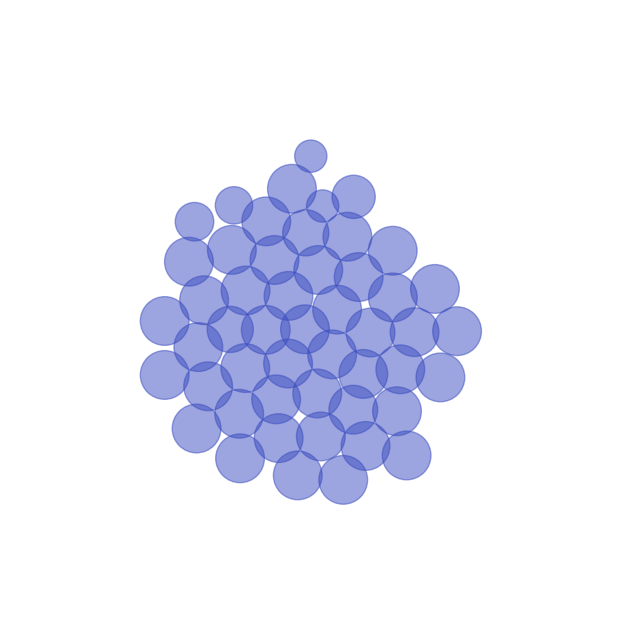

In [26]:
draw_circles_ctype(s);

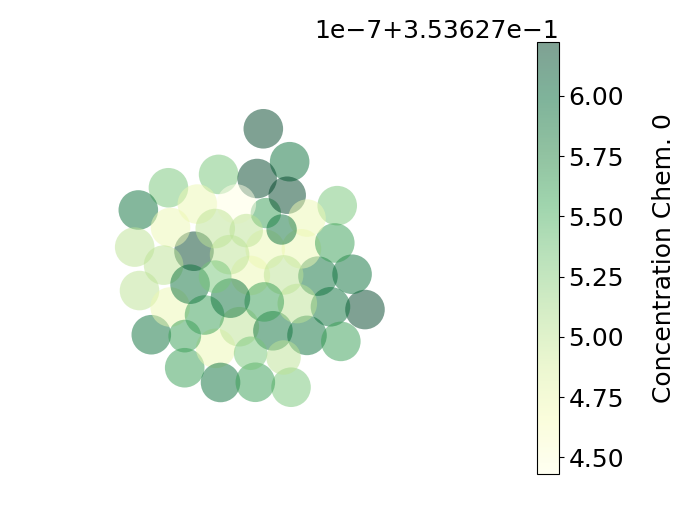

In [41]:
draw_circles_chem(s, 0);

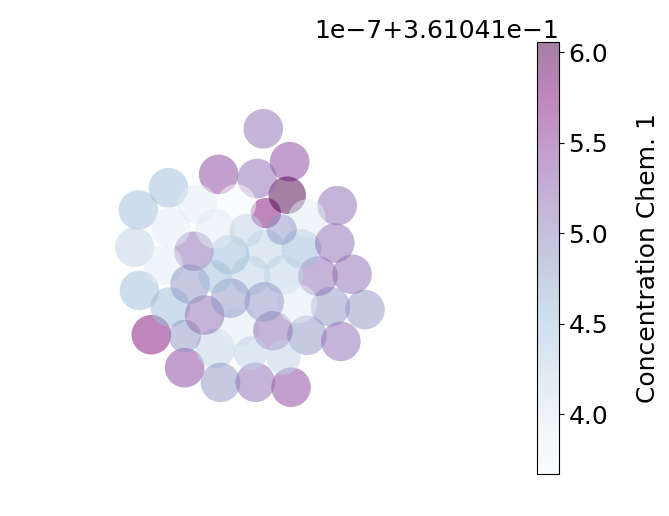

In [42]:
draw_circles_chem(s, 1);

In [53]:
s.celltype.sum(1)

Array([1.        , 1.        , 1.        , 1.        , 0.9999999 ,
       0.9999999 , 0.9999998 , 1.        , 1.0000001 , 0.9999999 ,
       0.9999999 , 0.99999994, 1.        , 1.0000001 , 0.99999994,
       1.0000001 , 0.9999999 , 0.9999999 , 0.9999999 , 1.        ,
       1.0000001 , 1.0000001 , 1.        , 1.        , 0.9999998 ,
       0.99999994, 1.        , 0.99999994, 0.99999994, 0.99999994,
       0.9999999 , 0.99999994, 1.        , 0.9999999 , 0.9999998 ,
       1.        , 0.9999998 , 0.9999998 , 1.        , 0.9999998 ,
       0.9999999 , 0.9999999 , 0.9999998 , 0.99999994, 0.9999998 ,
       1.        , 1.0000001 , 0.99999994, 1.0000001 , 1.        ],      dtype=float32)